In this notebook we are looking into optimizing a linear regressor (a single linear neuron) using gradient descent. 
The key takeaways are:

Conceptual:
1. Be able to explain what a gradient descent in two dimensions is.
2. Be able to explain the main components of a deep learning optimization workflow:
    - Obtaining and exploring the data
    - Setting up a model
    - Setting up a loss function
    - Choosing an optimizer and its parameters (e.g. learning rate)
    - Running a training-loop
    - Evaluating the performance using success metrices (e.g. accuracy) on a validation and test sets (this is not part of this notebook)

Technical:
1. Gain experience with tensor-indexing and tensor arithmetic; Know how to use `matmul`.
2. Explain the concepts and be able to hand-code them: 
    - weights
    - linear nodes/neurons
    - forward-pass (predict)
    - loss-function
    - gradient descent and learning rate
    - training loop
3. Get acquainted with exploring the data, numerically and by using Matplotlib. Be able to use Matplotlib to run the required visualization.

In [1]:
import torch
import matplotlib.pyplot as plt
import helpers as h
from math import floor, ceil

In [2]:
torch.manual_seed(42)

### Setting the Data

In [3]:
NUMBER_OF_DATA_POINTS = 4
X_RANGE = {
    'min': 0,
    'max': 2
}
SLOPE = 3
INTERCEPT = 4
NOISE_RANGE = 1.5
m = NUMBER_OF_DATA_POINTS  # the number of instances

def generate_data(
    x_range:dict[str, str]=X_RANGE,
    number_of_data_points:int=NUMBER_OF_DATA_POINTS,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE
    ) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Generates data for linear regression.
    """
    range = X_RANGE['max'] - X_RANGE['min']
    X = x_range['min'] + (range * torch.rand(size=(number_of_data_points, 1)))  # randomly-generated x-values, taken from a uniform distribution within `x_range`
    y = intercept + (slope * X) + (((torch.rand(size=(number_of_data_points, 1)) - 0.5) * 2) * noise_range)  # y-values with uniformly distributed noise added
    return X, y

def calculate_y_range(
    x_range:dict[str, str]=X_RANGE,
    slope:float=SLOPE,
    intercept:float=INTERCEPT,
    noise_range:float=NOISE_RANGE,
    ) -> float:
    """
    Calculates the maximum y-value for a given x-range, taking into account the maximum noise.
    """
    y_range = {}
    if slope >= 0:
        y_range['min'] = intercept + (slope * x_range['min']) - noise_range
        y_range['max'] = intercept + (slope * x_range['max']) + noise_range
    elif slope < 0:
        y_range['min'] = intercept + (slope * x_range['min']) + noise_range
        y_range['max'] = intercept + (slope * x_range['max']) - noise_range
    return y_range

X, y = generate_data()
y_range = calculate_y_range()

In [4]:
h.print_tensor_info(X, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.7645],
        [1.8300],
        [0.7657],
        [1.9186]])
Dimension    2
Shape        (4, 1)


The many PyTorch (and Tensorflow) functions expect their input to be in the shape of (batch_size, features). Note that above `X` was defined accordingly. The number of data points (also called _instances_ or _data instances_), is generally always on the 0th dimension. 

In [5]:
h.print_tensor_info(y, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[ 8.9650],
        [ 9.7927],
        [ 5.5669],
        [10.6368]])
Dimension    2
Shape        (4, 1)


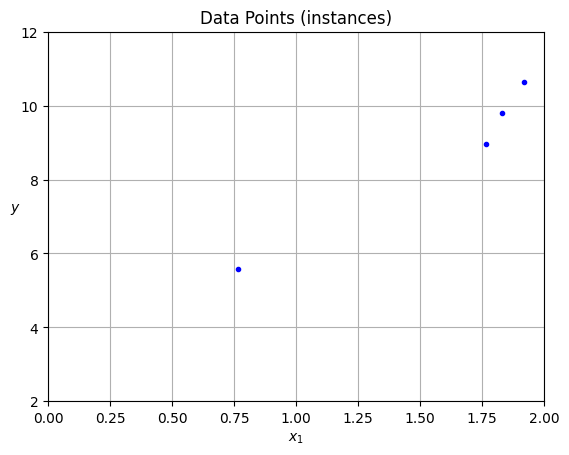

In [6]:
def plot_data_points(X, y):
    plt.plot(X, y, "b.")
    plt.xlabel("$x_1$")
    plt.ylabel("$y$", rotation=0)
    plt.title("Data Points (instances)")
    plt.axis([X_RANGE['min'], X_RANGE['max'], floor(y_range['min']), ceil(y_range['max'])])
    plt.grid()
    plt.show()
    return

plot_data_points(X, y)

### Preprocessing the Data

Now we are adding a dummy input parameter, that is equal to one for all instances: $x_0=1$.
This will allow us to use a single matrix multiplication for the equation $y =  w_0*1 + w_1*x_1$. It  is the generic form of a 1-dimensional linear equation. 

(for additional optional context, see: [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.add_dummy_feature.html))

In [9]:
X_extended = torch.cat((torch.full(size=X.shape, fill_value=1), X), dim=1)

In [10]:
h.print_tensor_info(X_extended, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.0000, 1.7645],
        [1.0000, 1.8300],
        [1.0000, 0.7657],
        [1.0000, 1.9186]])
Dimension    2
Shape        (4, 2)


### Defining the Model
With this form of input we can define the parameters: $w_0$ and $w_1$.
The equation is $y = w_0*x_0 + w_1*x_1$, or in a matrix notation: $y = X @ W$.
It might be helpful to write with PyTorch. 

In [11]:
def model(X, W):
    return X @ W

Let's assign values to our parameters, $W$

In [12]:
W = torch.tensor([[1.], [2.]])  
# The common practice is to set the parameters randomly. 
# Here we manually set them to 1 and 2.
# TODO (for interested students) change the above to a random initialization, and see what happens.
# Then change it to a zero initialization, and see what happens.
# Lastly, try setting it to the mean of the y values, with zero slope.

In [13]:
h.print_tensor_info(W, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[1.],
        [2.]])
Dimension    2
Shape        (2, 1)


In [14]:
def predict(X: torch.Tensor, W: torch.Tensor, is_preprocessed=False) -> torch.Tensor:
    """
    Calculates the value of a linear function with parameters W at points X.

    X: torch tensor of shape (number_of_points_to_predict, 1)
    W: torch tensor of shape (2, 1)
    return: torch tensor of shape (number_of_points_to_predict, 1)

    """
    if is_preprocessed:
        X_extended = X
    else:
        X_extended = torch.cat((torch.full(X.shape, 1), X), 1)  # preprocess
    y_predicted = model(X_extended, W)
    return y_predicted

In [15]:
y_predicted = predict(X_extended, W, is_preprocessed=True)

In [16]:
h.print_tensor_info(y_predicted, fields=['Tensor', 'Dimension', 'Shape'])

tensor([[4.5291],
        [4.6600],
        [2.5315],
        [4.8372]])
Dimension    2
Shape        (4, 1)


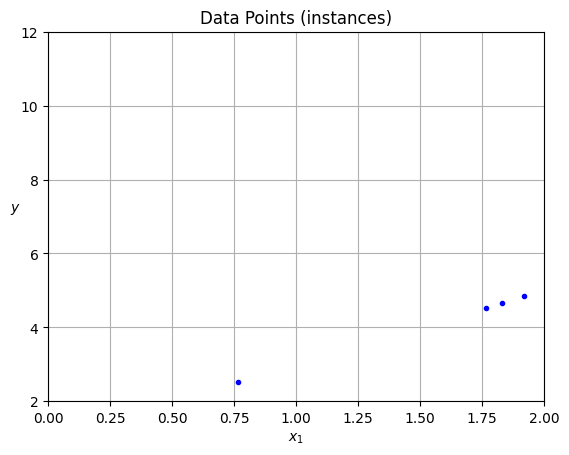

In [17]:
plot_data_points(X, y_predicted)

Let's plot the data points and the predictions (based on the initial $W$) on the same graph: 

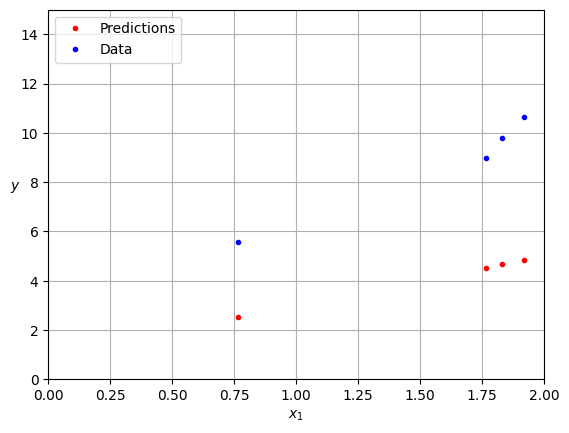

In [18]:
plt.plot(X, y_predicted, "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

### Setting up a Loss Function
A loss-function defines the value to be optimized (minimized).

The loss function we are going to use is the mean squared error (MSE):

$L=\frac{1}{m}*\sum_{n=1} ^{m} (y_{predicted, n} - y_n)^2$

Question: what is the difference between a MSE and Mean Absolute Error (MAE)? When would we use each? Will using MAE instead of MSE make a difference in the case of linear regression?

In [19]:
def loss(y_predicted, y):
    mse = ((y_predicted - y) ** 2).mean()  # mean squared error. This is equivalent to: torch.sum((y_predicted - y)**2)/y.numel()
    return mse

In [20]:
# First, demonstrating the calculation of the loss for each instance:
print('Squared error per instance:')
print((y_predicted - y)**2)

Squared error per instance:
tensor([[19.6771],
        [26.3445],
        [ 9.2139],
        [33.6346]])


In [21]:
mse = torch.sum((y_predicted - y)**2)/y.numel()
print(f'MSE: {mse:.4}')

MSE: 22.22


In [22]:
mse = loss(y_predicted, y)
print(f'MSE: {mse:.4}')

MSE: 22.22


### Optimization
Next we can manually calculate the derivative and use it for gradient descent

The cost function per instance is: $(w0 + w_1*x_1 - y)^2$
There are two partial derivatives for this equation, one for each of the two parameters:

$\frac{\partial(F)}{\partial(w_0)} = 2*(w0 + w_1*x_1 - y)$

$\frac{\partial(F)}{\partial(w_1)} = 2*(w0 + w_1*x_1 - y)*x_1$

Let's look at these equations to gain some intution. The difference between the two is the multiplciation by $x_1$ for $\frac{\partial(f)}{\partial(w_1)}$ but not for $\frac{\partial(f)}{\partial(w_0)}$. This make intuitive sense, given that as $x_1$ is larger, a change in the slope ($w_1$) would have a larger effect on `y_predicted`. A change in `w_1` for larger `x_1` results in a larger difference in the loss function value compared to a smaller `x_1`. 

On the other hand, a change in `w_0` will have the same effect on the loss function value, regardless of the data (`x_1`).

This is what the gradient tell us.

In [24]:
# calculating the gradient:
d_w0 = 2*(X_extended @ W - y)
d_w1 = 2*(X_extended @ W - y) * X_extended[:, 1].reshape(-1, 1)

In [29]:
d_w0

tensor([[ -8.8718],
        [-10.2654],
        [ -6.0709],
        [-11.5991]])

In [30]:
d_w1

tensor([[-15.6546],
        [-18.7857],
        [ -4.6486],
        [-22.2541]])

And the _mean_ partial derivative over all instances is:

In [31]:
d_w0_mean = torch.mean(d_w0)
d_w1_mean = torch.mean(d_w1)
print(f'd_w0_mean: {d_w0_mean:.4}')
print(f'd_w1_mean: {d_w1_mean:.4}')

d_w0_mean: -9.202
d_w1_mean: -15.34


Notice that the gradient points to the direction of maximum increase of the loss function. And since the loss needs to be minimized, the direction that should be taken to minimize the function is opposite to the direction of the gradient. So the direction of gradient descent is opposite to the direction of the gradient. 

Now we can define a learning rate, which is a multiplier of the gradient:

In [32]:
lr = 0.02
print(f'Learning Rate: {lr:.4}')

Learning Rate: 0.02


Let's run the first iteration, and take a look at the value of the parameters.

In [33]:
# TODO: (for students) Here we want to simply print W before and after applying the gradients.model
# For this, we need to define W_new by _cloning_ the original W. 
# why is this necessary? Can you explain? 
# More precisely, what is the difference between `W_new = W`` and `W_new = W.clone()`?
W_new = W.clone()

In [34]:
W_new[0] = W_new[0] - lr * d_w0_mean
W_new[1] = W_new[1] - lr * d_w1_mean
print(W)
print(W_new)

tensor([[1.],
        [2.]])
tensor([[1.1840],
        [2.3067]])


In [35]:
y_predicted = predict(X_extended, W_new, is_preprocessed=True)

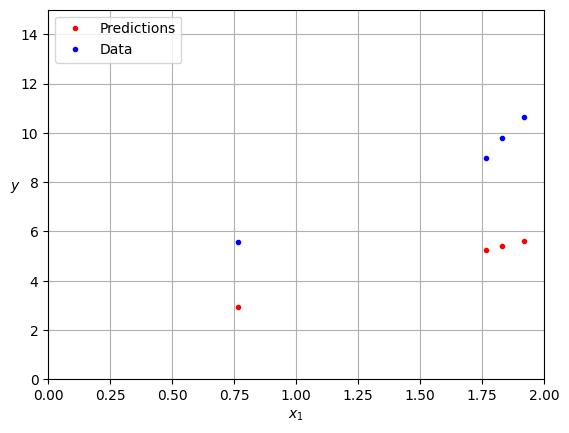

In [36]:
plt.plot(X, y_predicted, "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

Now let's run multiple iterations of this gradient-descent optimization process.

In [37]:
for epoch in range(25):
    y_predicted = predict(X_extended, W, is_preprocessed=True)
    mse = torch.sum((y_predicted - y)**2)/y.numel()
    d_w0_mean = torch.mean(2*(X_extended @ W - y))
    d_w1_mean = torch.mean(2*(X_extended @ W - y) * X_extended[:, 1].reshape(-1, 1))
    W[0] = W[0] - lr * d_w0_mean
    W[1] = W[1] - lr * d_w1_mean
    print(f'Epoch {epoch}: MSE: {mse:.4} W_0: {W.numpy()[0][0]:.4} W_1: {W.numpy()[1][0]:.4}')

Epoch 0: MSE: 22.22 W_0: 1.184 W_1: 2.307
Epoch 1: MSE: 16.28 W_0: 1.341 W_1: 2.569
Epoch 2: MSE: 11.94 W_0: 1.476 W_1: 2.793
Epoch 3: MSE: 8.772 W_0: 1.591 W_1: 2.985
Epoch 4: MSE: 6.452 W_0: 1.69 W_1: 3.149
Epoch 5: MSE: 4.756 W_0: 1.774 W_1: 3.289
Epoch 6: MSE: 3.516 W_0: 1.846 W_1: 3.409
Epoch 7: MSE: 2.609 W_0: 1.908 W_1: 3.511
Epoch 8: MSE: 1.945 W_0: 1.961 W_1: 3.599
Epoch 9: MSE: 1.46 W_0: 2.006 W_1: 3.674
Epoch 10: MSE: 1.106 W_0: 2.045 W_1: 3.738
Epoch 11: MSE: 0.8465 W_0: 2.078 W_1: 3.792
Epoch 12: MSE: 0.6569 W_0: 2.106 W_1: 3.839
Epoch 13: MSE: 0.5182 W_0: 2.131 W_1: 3.879
Epoch 14: MSE: 0.4168 W_0: 2.151 W_1: 3.913
Epoch 15: MSE: 0.3427 W_0: 2.169 W_1: 3.942
Epoch 16: MSE: 0.2885 W_0: 2.185 W_1: 3.967
Epoch 17: MSE: 0.2488 W_0: 2.198 W_1: 3.988
Epoch 18: MSE: 0.2199 W_0: 2.209 W_1: 4.006
Epoch 19: MSE: 0.1987 W_0: 2.219 W_1: 4.022
Epoch 20: MSE: 0.1832 W_0: 2.227 W_1: 4.035
Epoch 21: MSE: 0.1718 W_0: 2.234 W_1: 4.047
Epoch 22: MSE: 0.1635 W_0: 2.24 W_1: 4.056
Epoch 23: MS

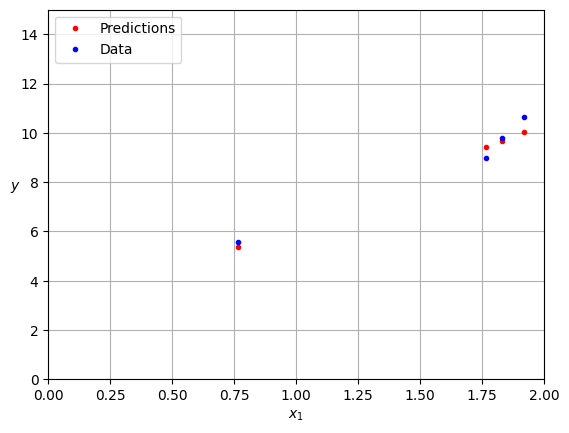

In [38]:
plt.plot(X, y_predicted, "r.", label="Predictions")
plt.plot(X, y, "b.", label="Data")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.legend(loc="upper left")

plt.show()

Optional Exercises for interested students: It might be interesting to see what happens if we change the learning rate. What happens if it is too large (e.g. equal to 1.0)?

### Note about Alternatives
There are other ways to solve a linear regression problem. In fact, thee is an exact method, the [ordinary least squares](https://en.wikipedia.org/wiki/Ordinary_least_squares) (with computational limitations on the number of data instances). It can be useful to compare the result we got to the ideal one.

In [40]:
ideal_w = torch.inverse(X_extended.T @ X_extended) @ X_extended.T @ y
print(ideal_w)
print(ideal_w.shape)
print(ideal_w.dim())

tensor([[2.3978],
        [4.0405]])
torch.Size([2, 1])
2


Exercises for interested students: 
1. Increase the number of data points from 4 to 20 or 100. Are there any code changes needed?
2. Increase the dimensionality of the input data from 1D to 2D, such that each data point has two numbers, $x_1$ and $x_2$ as inputs. Graphically, this means that $y$ is plotted as a function of $(x_1, x_2)$ in 3D. What would be the regressor? A line? A 2D plane?